In [1]:
import os
import utils.extract_features
import utils.common
import sklearn
import re
import keras
import numpy as np
import librosa
from tqdm.notebook import tqdm
import network
import matplotlib.pyplot as plt 

In [72]:
input_dir = r"C:\Users\Sulakshana\Documents\GitHub\speech-emotion-recognition\check"
# generate and save features
utils.extract_features.extract_features_from_files(input_dir)
print("features extracted!")
# read features
input_dir = "features"
res_dict = utils.common.read_features(input_dir)

Number of files:  60
features\03-01-01-01-01-01-01.npz
features\03-01-01-01-01-02-01.npz
features\03-01-01-01-02-01-01.npz
features\03-01-01-01-02-02-01.npz
features\03-01-02-01-01-01-01.npz
features\03-01-02-01-01-02-01.npz
features\03-01-02-01-02-01-01.npz
features\03-01-02-01-02-02-01.npz
features\03-01-02-02-01-01-01.npz
features\03-01-02-02-01-02-01.npz
features\03-01-02-02-02-01-01.npz
features\03-01-02-02-02-02-01.npz
features\03-01-03-01-01-01-01.npz
features\03-01-03-01-01-02-01.npz
features\03-01-03-01-02-01-01.npz
features\03-01-03-01-02-02-01.npz
features\03-01-03-02-01-01-01.npz
features\03-01-03-02-01-02-01.npz
features\03-01-03-02-02-01-01.npz
features\03-01-03-02-02-02-01.npz
features\03-01-04-01-01-01-01.npz
features\03-01-04-01-01-02-01.npz
features\03-01-04-01-02-01-01.npz
features\03-01-04-01-02-02-01.npz
features\03-01-04-02-01-01-01.npz
features\03-01-04-02-01-02-01.npz
features\03-01-04-02-02-01-01.npz
features\03-01-04-02-02-02-01.npz
features\03-01-05-01-01-01-

In [73]:
res_dict.keys()

dict_keys(['mel', 'pitch', 'egmaps', 'label', 'mfcc'])

In [74]:
# check shapes
res_dict['mel'].shape,res_dict['pitch'].shape,res_dict['egmaps'].shape,res_dict['label'].shape,res_dict['mfcc'].shape

((1440, 64), (1440,), (1440, 25), (1440,), (1440, 40))

In [75]:
features = ['mel_spectogram','egmaps','mel_spectogram_w_pitch','mel_spectogram_w_egmaps']

# normalise
mel_spectogram_data = (res_dict['mel'] - np.mean(res_dict['mel'],axis = 0))/np.std(res_dict['mel'],axis =0)
pitch_data = (res_dict['pitch'] - np.mean(res_dict['pitch']))/np.std(res_dict['pitch'])
egmaps_data = (res_dict['egmaps'] - np.mean(res_dict['egmaps'],axis = 0))/np.std(res_dict['egmaps'],axis =0)
mfcc_data = (res_dict['mfcc'] - np.mean(res_dict['mfcc'],axis =0))/np.std(res_dict['mfcc'],axis =0)

In [99]:
# train test split

number_of_datapoints = mel_spectogram_data.shape[0]
indexes = np.random.permutation(number_of_datapoints)
train_idx = indexes[:int(number_of_datapoints*0.8)]
val_idx = indexes[int(number_of_datapoints*0.8):int(number_of_datapoints*0.9)]
test_idx = indexes[int(number_of_datapoints*0.9):]

input_features ={}
input_features['mel'] = {}
input_features['mel']['train'] = mel_spectogram_data[train_idx]
input_features['mel']['val'] = mel_spectogram_data[val_idx]
input_features['mel']['test'] = mel_spectogram_data[test_idx]

pitch_data_train = pitch_data[train_idx].reshape(-1,1)
pitch_data_val = pitch_data[val_idx].reshape(-1,1)
pitch_data_test = pitch_data[test_idx].reshape(-1,1)

input_features['mel_and_pitch'] = {}
input_features['mel_and_pitch']['train'] = np.concatenate((mel_spectogram_data[train_idx],pitch_data_train),axis =1)
input_features['mel_and_pitch']['val'] = np.concatenate((mel_spectogram_data[val_idx],pitch_data_val),axis =1)
input_features['mel_and_pitch']['test'] = np.concatenate((mel_spectogram_data[val_idx],pitch_data_test),axis =1)

input_features['mel_and_egmaps'] = {}
input_features['mel_and_egmaps']['train'] = np.concatenate((mel_spectogram_data[train_idx],egmaps_data[train_idx]),axis =1)
input_features['mel_and_egmaps']['val'] = np.concatenate((mel_spectogram_data[val_idx],egmaps_data[val_idx]),axis =1)
input_features['mel_and_egmaps']['test'] = np.concatenate((mel_spectogram_data[val_idx],egmaps_data[test_idx]),axis =1)

input_features['mfcc'] = {}
input_features['mfcc']['train'] = mfcc_data[train_idx] 
input_features['mfcc']['val'] =  mfcc_data[val_idx]
input_features['mfcc']['test'] =  mfcc_data[test_idx]

input_features['egmaps'] = {}
input_features['egmaps']['train'] = egmaps_data[train_idx] 
input_features['egmaps']['val'] =  egmaps_data[val_idx]
input_features['egmaps']['test'] =  egmaps_data[test_idx]

input_features['mfcc_and_pitch'] = {}
input_features['mfcc_and_pitch']['train'] = np.concatenate((mfcc_data[train_idx],pitch_data_train),axis =1)
input_features['mfcc_and_pitch']['val'] = np.concatenate((mfcc_data[val_idx],pitch_data_val),axis =1)
input_features['mfcc_and_pitch']['test'] = np.concatenate((mfcc_data[val_idx],pitch_data_test),axis =1)

input_features['mfcc_and_egmaps'] = {}
input_features['mfcc_and_egmaps']['train'] = np.concatenate((mfcc_data[train_idx],egmaps_data[train_idx]),axis =1)
input_features['mfcc_and_egmaps']['val'] = np.concatenate((mfcc_data[val_idx],egmaps_data[val_idx]),axis =1)
input_features['mfcc_and_egmaps']['test'] = np.concatenate((mfcc_data[val_idx],egmaps_data[test_idx]),axis =1)

y={}
y['train'],y['val'],y['test'] = res_dict['label'][train_idx],res_dict['label'][val_idx],res_dict['label'][test_idx]

In [102]:
# check shapes
(input_features['mel_and_egmaps']['train'].shape,input_features['mel_and_egmaps']['test'].shape,input_features['mel_and_egmaps']['val'].shape,
input_features['mfcc_and_egmaps']['train'].shape,input_features['mfcc_and_egmaps']['test'].shape,input_features['mfcc_and_egmaps']['val'].shape)

((1152, 89), (144, 89), (144, 89), (1152, 65), (144, 65), (144, 65))

In [103]:
metrics = {}
for key in input_features.keys():
    X_train,X_val,X_test = input_features[key]['train'],input_features[key]['val'],input_features[key]['test']
    y_train,y_val,y_test = y['train'],y['val'],y['test']
    input_shape = (input_features[key]['train'].shape[1],1)
    model = network.SER_CNN(input_shape)
    opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

    model_name = f'SER_weights_{key}.hdf5'
    checkpoint = keras.callbacks.ModelCheckpoint(model_name, save_best_only=True, monitor='accuracy', mode='max')
    cnnhistory=model.fit(input_features[key]['train'], y['train'],
            batch_size=16, 
            epochs=10,
            validation_data=(input_features[key]['val'],  y['val']),
            callbacks = [checkpoint])

    metrics[key] = {}
    metrics[key]['loss'] = cnnhistory.history['loss']
    metrics[key]['val_loss'] = cnnhistory.history['val_loss']

    
    metrics[key]['accuracy'] = cnnhistory.history['accuracy']
    metrics[key]['val_accuracy'] = cnnhistory.history['val_accuracy']

   
    save_dir = 'Ravdess_models'
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

Epoch 1/10
72/72 [==============================] - 2s 20ms/step - loss: 2.1928 - accuracy: 0.1849 - val_loss: 2.1241 - val_accuracy: 0.2222
Epoch 2/10
72/72 [==============================] - 1s 15ms/step - loss: 2.0864 - accuracy: 0.2214 - val_loss: 2.0447 - val_accuracy: 0.2222
Epoch 3/10
72/72 [==============================] - 1s 13ms/step - loss: 2.0252 - accuracy: 0.2179 - val_loss: 1.9919 - val_accuracy: 0.2222
Epoch 4/10
72/72 [==============================] - 1s 8ms/step - loss: 1.9861 - accuracy: 0.2231 - val_loss: 1.9623 - val_accuracy: 0.2292
Epoch 5/10
72/72 [==============================] - 1s 9ms/step - loss: 1.9620 - accuracy: 0.2179 - val_loss: 1.9405 - val_accuracy: 0.2361
Epoch 6/10
72/72 [==============================] - 1s 10ms/step - loss: 1.9429 - accuracy: 0.2413 - val_loss: 1.9266 - val_accuracy: 0.2361
Epoch 7/10
72/72 [==============================] - 0s 7ms/step - loss: 1.9361 - accuracy: 0.2300 - val_loss: 1.9125 - val_accuracy: 0.2431
Epoch 8/10
72/72

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_4 (Activation)   (None, 5, 128)            0         
                                                      

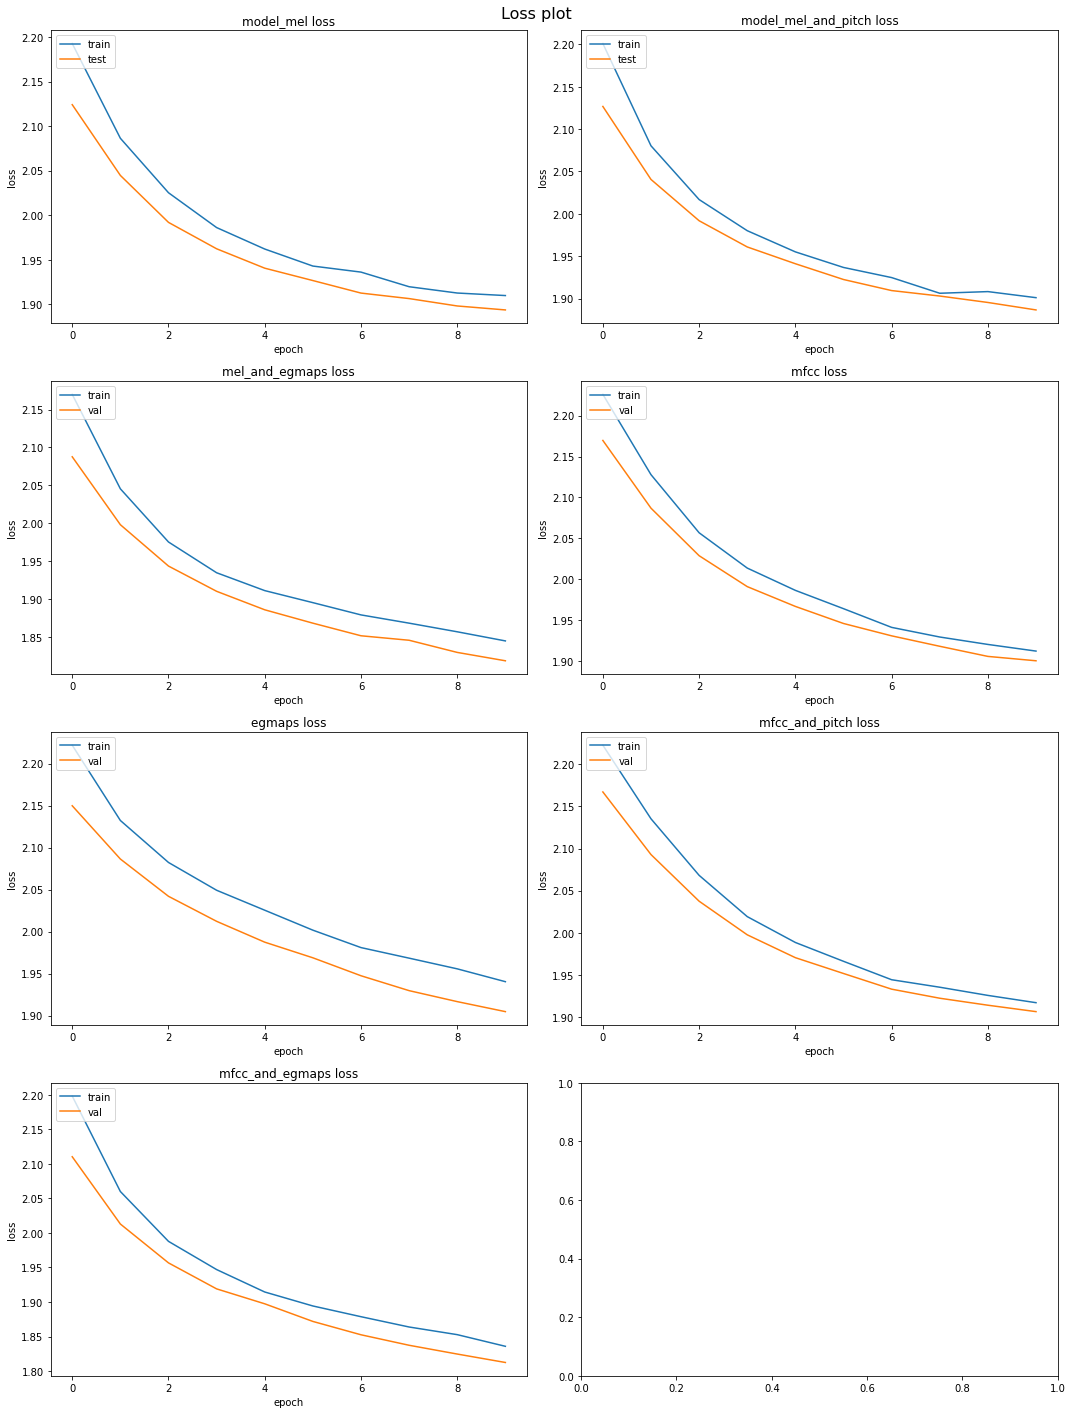

In [106]:
plt.rcParams['figure.figsize'] = (15,20)
fig,axs = plt.subplots(4,2)

axs[0][0].plot(metrics['mel']['loss'])
axs[0][0].plot(metrics['mel']['val_loss'])
axs[0][0].set_title('model_mel loss')
axs[0][0].set_ylabel('loss')
axs[0][0].set_xlabel('epoch')
axs[0][0].legend(['train', 'test'], loc='upper left')

axs[0][1].plot(metrics['mel_and_pitch']['loss'])
axs[0][1].plot(metrics['mel_and_pitch']['val_loss'])
axs[0][1].set_title('model_mel_and_pitch loss')
axs[0][1].set_ylabel('loss')
axs[0][1].set_xlabel('epoch')
axs[0][1].legend(['train', 'test'], loc='upper left')

axs[1][0].plot(metrics['mel_and_egmaps']['loss'])
axs[1][0].plot(metrics['mel_and_egmaps']['val_loss'])
axs[1][0].set_title('mel_and_egmaps loss')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlabel('epoch')
axs[1][0].legend(['train', 'val'], loc='upper left')

axs[1][1].plot(metrics['mfcc']['loss'])
axs[1][1].plot(metrics['mfcc']['val_loss'])
axs[1][1].set_title('mfcc loss')
axs[1][1].set_ylabel('loss')
axs[1][1].set_xlabel('epoch')
axs[1][1].legend(['train', 'val'], loc='upper left')

axs[2][0].plot(metrics['egmaps']['loss'])
axs[2][0].plot(metrics['egmaps']['val_loss'])
axs[2][0].set_title('egmaps loss')
axs[2][0].set_ylabel('loss')
axs[2][0].set_xlabel('epoch')
axs[2][0].legend(['train', 'val'], loc='upper left')

axs[2][1].plot(metrics['mfcc_and_pitch']['loss'])
axs[2][1].plot(metrics['mfcc_and_pitch']['val_loss'])
axs[2][1].set_title('mfcc_and_pitch loss')
axs[2][1].set_ylabel('loss')
axs[2][1].set_xlabel('epoch')
axs[2][1].legend(['train', 'val'], loc='upper left')

axs[3][0].plot(metrics['mfcc_and_egmaps']['loss'])
axs[3][0].plot(metrics['mfcc_and_egmaps']['val_loss'])
axs[3][0].set_title('mfcc_and_egmaps loss')
axs[3][0].set_ylabel('loss')
axs[3][0].set_xlabel('epoch')
axs[3][0].legend(['train', 'val'], loc='upper left')



fig.suptitle('Loss plot',size = 16)
fig.tight_layout()
plt.show()

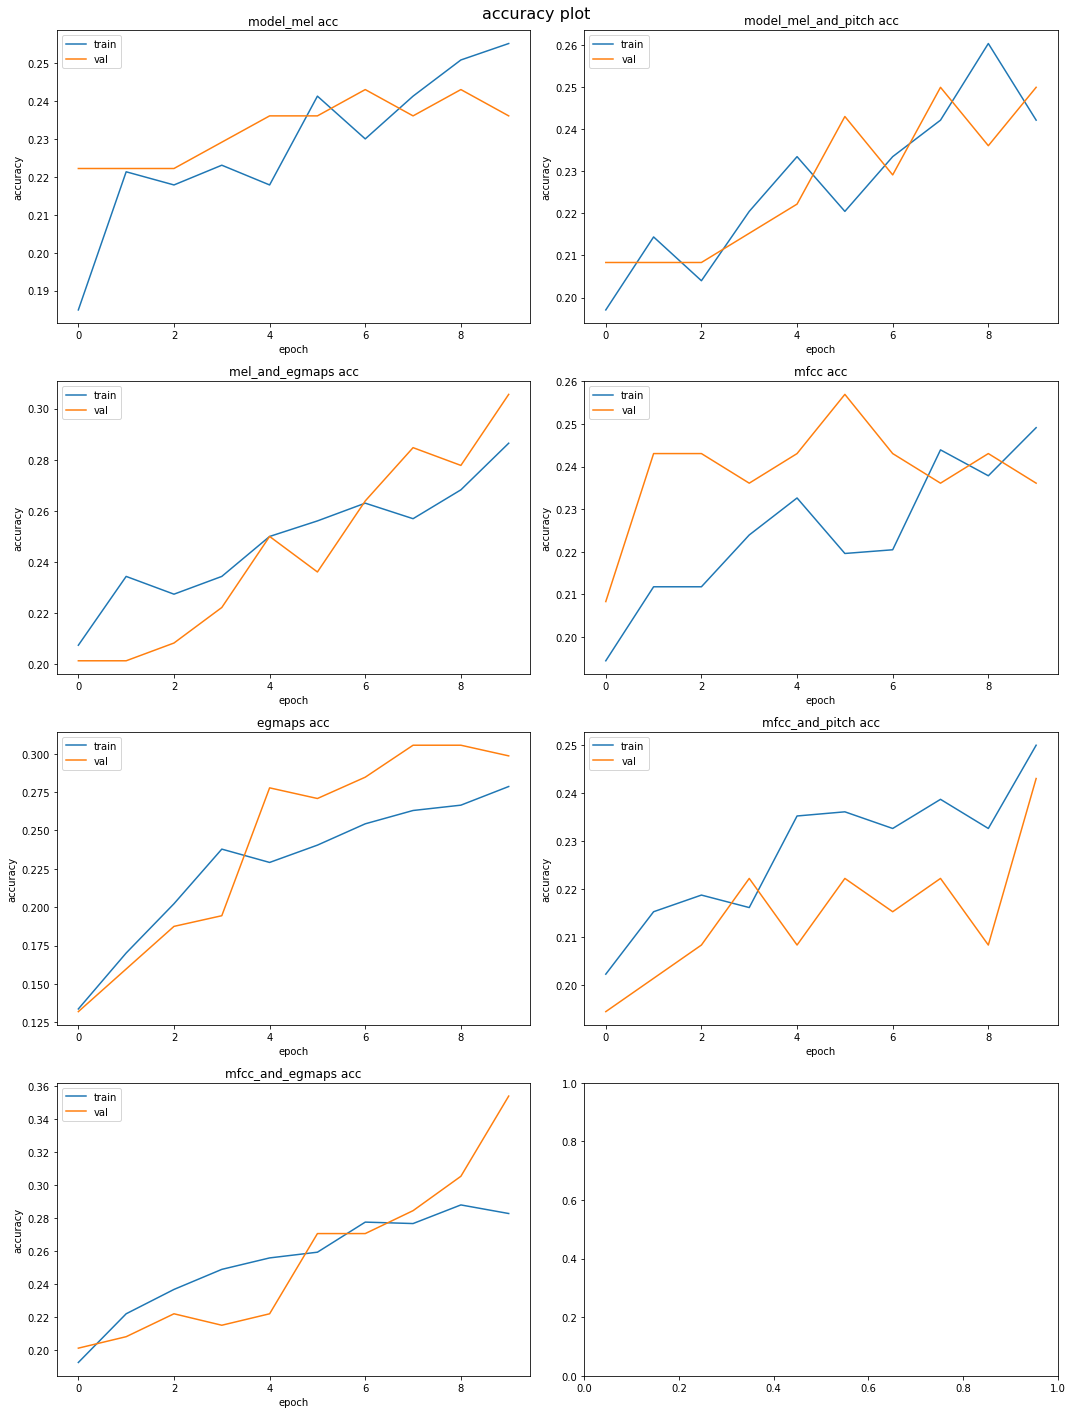

In [108]:
plt.rcParams['figure.figsize'] = (15,20)
fig,axs = plt.subplots(4,2)

axs[0][0].plot(metrics['mel']['accuracy'])
axs[0][0].plot(metrics['mel']['val_accuracy'])
axs[0][0].set_title('model_mel acc')
axs[0][0].set_ylabel('accuracy')
axs[0][0].set_xlabel('epoch')
axs[0][0].legend(['train', 'val'], loc='upper left')

axs[0][1].plot(metrics['mel_and_pitch']['accuracy'])
axs[0][1].plot(metrics['mel_and_pitch']['val_accuracy'])
axs[0][1].set_title('model_mel_and_pitch acc')
axs[0][1].set_ylabel('accuracy')
axs[0][1].set_xlabel('epoch')
axs[0][1].legend(['train', 'val'], loc='upper left')

axs[1][0].plot(metrics['mel_and_egmaps']['accuracy'])
axs[1][0].plot(metrics['mel_and_egmaps']['val_accuracy'])
axs[1][0].set_title('mel_and_egmaps acc')
axs[1][0].set_ylabel('accuracy')
axs[1][0].set_xlabel('epoch')
axs[1][0].legend(['train', 'val'], loc='upper left')

axs[1][1].plot(metrics['mfcc']['accuracy'])
axs[1][1].plot(metrics['mfcc']['val_accuracy'])
axs[1][1].set_title('mfcc acc')
axs[1][1].set_ylabel('accuracy')
axs[1][1].set_xlabel('epoch')
axs[1][1].legend(['train', 'val'], loc='upper left')

axs[2][0].plot(metrics['egmaps']['accuracy'])
axs[2][0].plot(metrics['egmaps']['val_accuracy'])
axs[2][0].set_title('egmaps acc')
axs[2][0].set_ylabel('accuracy')
axs[2][0].set_xlabel('epoch')
axs[2][0].legend(['train', 'val'], loc='upper left')

axs[2][1].plot(metrics['mfcc_and_pitch']['accuracy'])
axs[2][1].plot(metrics['mfcc_and_pitch']['val_accuracy'])
axs[2][1].set_title('mfcc_and_pitch acc')
axs[2][1].set_ylabel('accuracy')
axs[2][1].set_xlabel('epoch')
axs[2][1].legend(['train', 'val'], loc='upper left')

axs[3][0].plot(metrics['mfcc_and_egmaps']['accuracy'])
axs[3][0].plot(metrics['mfcc_and_egmaps']['val_accuracy'])
axs[3][0].set_title('mfcc_and_egmaps acc')
axs[3][0].set_ylabel('accuracy')
axs[3][0].set_xlabel('epoch')
axs[3][0].legend(['train', 'val'], loc='upper left')


fig.suptitle('accuracy plot',size = 16)
fig.tight_layout()
plt.show()


# plt.plot(cnnhistory.history['accuracy'])
# plt.plot(cnnhistory.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [109]:
for key in input_features.keys():
    save_dir = 'Ravdess_models'
    # Save model and weights
    model_name = f'SER_weights_{key}.hdf5'

    model_path = os.path.join(save_dir, model_name)

    loaded_model = keras.models.load_model(model_name)
    loss, acc = loaded_model.evaluate(input_features[key]['test'], y['test'])
    print("-----------------------------------------------------------------------------")
    print(f"Restored {model_name} accuracy: {100*acc:5.2f}%")
    print("-----------------------------------------------------------------------------")


5/5 [==============================] - 0s 4ms/step - loss: 1.8719 - accuracy: 0.2500
-----------------------------------------------------------------------------
Restored SER_weights_mel.hdf5 accuracy: 25.00%
-----------------------------------------------------------------------------
5/5 [==============================] - 0s 3ms/step - loss: 2.2765 - accuracy: 0.1389
-----------------------------------------------------------------------------
Restored SER_weights_mel_and_pitch.hdf5 accuracy: 13.89%
-----------------------------------------------------------------------------
5/5 [==============================] - 0s 4ms/step - loss: 2.2142 - accuracy: 0.1319
-----------------------------------------------------------------------------
Restored SER_weights_mel_and_egmaps.hdf5 accuracy: 13.19%
-----------------------------------------------------------------------------
5/5 [==============================] - 0s 3ms/step - loss: 1.8828 - accuracy: 0.2500
------------------------------

### OLD VER

In [35]:
zip(file_paths, labels)

In [36]:
window_len = 3.5
augment_factor = 1
sr = 16000

n_samples = int(window_len * sr)
mel_spec_list = []
audio_list = []
label_list = []
egmap_list = []
pitch_list = []
print("Number of files: ",len(file_paths))
for file,label in zip(file_paths,labels):
    signal = utils.load_audio(file,sr=16000)
    n_windows = int(signal.shape[0] // n_samples) * augment_factor
    n_correct_windows = 0
    # print("n_windows: ",n_windows)
    for i in range(n_windows):
        audio_frames = signal[ int(n_samples * i / augment_factor):int(n_samples * (1 + i / augment_factor))]
        audio_list.append(audio_frames)
        label_list.append(label)
        mel_spec_list.append(utils.extract_mel_spectogram(audio_frames))
        # pitch,egmaps= utils.extract_features_from_file(audio_frames)
        # egmap_list.append(egmaps)
        # pitch_list.append(pitch)



audio_arr = np.array(audio_list)      
label_arr = np.array(label_list) 
mel_spec_arr = np.array(mel_spec_list)
# egmaps_arr = np.array(egmap_list)
# pitch_arr = np.array(pitch_list)







Number of files:  1440


In [15]:
label_arr.shape,mel_spec_arr.shape#,egmaps_arr.shape,pitch_arr.shape

((106,), (106, 348, 64, 1), (106, 348, 25), (106, 348))

In [38]:
data_mel = mel_spec_arr.squeeze()
# pitch_arr_reshaped = pitch_arr[:,:,np.newaxis]
# data_mel_pitch = np.concatenate((data_mel,pitch_arr_reshaped),axis =2 )
# data_mel.shape,pitch_arr_reshaped.shape,data_mel_pitch.shape

In [39]:
number_of_datapoints = data_mel.shape[0]
indexes = np.random.permutation(number_of_datapoints)
train_idx = indexes[:int(number_of_datapoints*0.8)]
test_idx = indexes[int(number_of_datapoints*0.8):]
train_data = data_mel[train_idx]
test_data = data_mel[test_idx]
label_train = label_arr[train_idx]
label_test = label_arr[test_idx]
train_data.shape,test_data.shape,label_train.shape

((850, 348, 64), (213, 348, 64), (850,))

In [40]:
test_data.shape

(213, 348, 64)

In [41]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
n_train =train_data.shape[0]
n_test = test_data.shape[0]

clf.fit(train_data.reshape(n_train,-1),label_train)
y_pred = clf.predict(test_data.reshape(n_test,-1))

In [42]:
np.mean(y_pred == label_test)

0.38967136150234744

In [43]:
np.unique(label_test)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [44]:
1/8

0.125

In [61]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from matplotlib.pyplot import specgram

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow import keras
# import keras
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import optimizers
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(348,64)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [62]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 348, 128)          41088     
                                                                 
 activation_21 (Activation)  (None, 348, 128)          0         
                                                                 
 dropout_14 (Dropout)        (None, 348, 128)          0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 43, 128)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 43, 128)           82048     
                                                                 
 activation_22 (Activation)  (None, 43, 128)           0         
                                                      

In [63]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [64]:
cnnhistory=model.fit(train_data, label_train, batch_size=16, epochs=30, validation_data=(test_data, label_test))


Epoch 1/30
54/54 [==============================] - 4s 52ms/step - loss: 2.6480 - accuracy: 0.1835 - val_loss: 2.5625 - val_accuracy: 0.2066
Epoch 2/30
54/54 [==============================] - 3s 48ms/step - loss: 1.9775 - accuracy: 0.2835 - val_loss: 1.9920 - val_accuracy: 0.2629
Epoch 3/30
54/54 [==============================] - 3s 47ms/step - loss: 1.8071 - accuracy: 0.3153 - val_loss: 1.8178 - val_accuracy: 0.3333
Epoch 4/30
54/54 [==============================] - 2s 46ms/step - loss: 1.6067 - accuracy: 0.3812 - val_loss: 1.7443 - val_accuracy: 0.3662
Epoch 5/30
54/54 [==============================] - 3s 62ms/step - loss: 1.4997 - accuracy: 0.4329 - val_loss: 1.7969 - val_accuracy: 0.2911
Epoch 6/30
54/54 [==============================] - 3s 61ms/step - loss: 1.3861 - accuracy: 0.4871 - val_loss: 1.7101 - val_accuracy: 0.3521
Epoch 7/30
54/54 [==============================] - 3s 59ms/step - loss: 1.3182 - accuracy: 0.5071 - val_loss: 1.6566 - val_accuracy: 0.4131
Epoch 8/30
54